In [1]:
from mphelper import ProcessWrapPool
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import itertools
import biodataplot.metaplot as bpm
from biodata.bigwig import BigWigIReader
from biodata.bed import BEDXReader
from genomictools import GenomicCollection
from biodatatools.utils.common import json_dump
import pysam
import pybedtools
import seaborn as sns
import sys
from pathlib import Path

In [2]:
matplotlib.font_manager.fontManager.addfont(f"{Path.cwd().parent}/font/Arial.ttf")
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [3]:
sys.path.append(f"{Path.cwd().parent}")
import utils

In [4]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

# Read length distribution

In [5]:
s = "C1"
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]
cs = ["", "_control"]
gs = [f"{p}_{d}{c}" for p, d, c in itertools.product(ps, ds, cs)]

## Get read length from bam files

In [20]:
# Only focus on R2 (this is what we used to generate 5' end bigwig files)

bam_in = f"{PROJECT_DIR_d}Analysis/{s}_dedup_chr1-22-X_R2.bam"
with pysam.AlignmentFile(bam_in, "rb") as samfile:
    results = [
        [read.reference_name, read.reference_start, read.reference_end, read.query_name, read.query_length]
        for read in samfile.fetch()
    ]
df = pd.DataFrame(results)
outputfile = f"{PROJECT_DIR_d}Analysis/{s}_R2_lengths.bed.gz"
df.to_csv(outputfile, index=False, header=None, sep="\t", compression="gzip")

## Get read length distribution

In [7]:
b1 = pybedtools.BedTool(f"{PROJECT_DIR_d}Analysis/{s}_R2_lengths.bed.gz")
results = []
for p, d in itertools.product(ps, ds):
	b2 = pybedtools.BedTool(f"{PROJECT_DIR_d}bed_plot/{s}_{p}_{d}.bed")
	overlap = b1.intersect(b2, wao=True)
	rs = set()
	for i in overlap:
		region = tuple(i.fields[:3])
		if int(i.fields[-1]) > 0 and region not in rs:
			results.append([p.capitalize(), d.capitalize(), int(i.fields[4])])
			rs.add(region)
df_len = pd.DataFrame(results, columns=["Group", "Subgroup", "Length"])

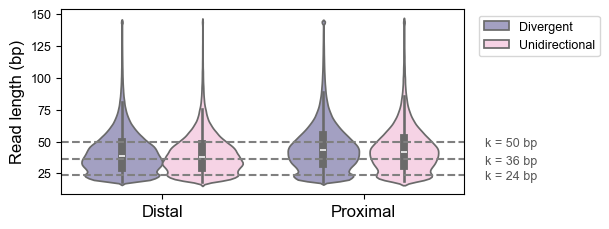

In [8]:
fig, ax = plt.subplots(figsize=(5.2,2.4))

hue_plot_params = {
					"data": df_len,
					"x": "Subgroup",
					"y": "Length",
					"order": ["Distal", "Proximal"],
					"hue": "Group",
					"hue_order": ["Divergent", "Unidirectional"],
					"palette": ["#9e9ac8", "#fccde5"]
					}
g = sns.violinplot(**hue_plot_params, ax=ax)

g.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=sfontsize)
g.set_ylabel("Read length (bp)", fontsize=bfontsize)
g.tick_params(axis="y", labelsize=sfontsize)

g.set_xlabel("")
g.tick_params(axis="x", labelsize=bfontsize)

for k in [24, 36, 50]:
	g.axhline(y=k, color="#808080", ls="--")
	g.text(1.6, k-4, f"k = {k} bp", fontsize=sfontsize, color="#575757")

outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig2a.pdf"
plt.savefig(outputfile, bbox_inches = "tight", transparent=True)

# Generate feature matrix

## Get individual matrix

In [9]:
bws = {}
ms = ["k24", "k36", "k50"]
for m in ms:
	bws[m] = f"{PROJECT_DIR_r}other/mappability/{m}.Umap.MultiTrackMappability.bw"

In [10]:
df_features = {}
for g in gs:
	bed = f"{PROJECT_DIR_d}bed_plot/{s}_{g}.bed"
	if "control" in bed:
		all_regions = BEDXReader.read_all(GenomicCollection, bed)
		use_strand = False
	else:
		all_regions = BEDXReader.read_all(GenomicCollection, bed, strandfield="f7")
		use_strand = True
	index = [f"{r.chrom}_{r.chromStart}_{r.chromEnd}" for r in all_regions]

	for m in bws:
		df_features[(m,g)] = pd.DataFrame(bpm.generate_signal_profile(all_regions, BigWigIReader(bws[m]), fixed_size=1001, use_strand=use_strand), index=index)

In [11]:
df_reformat = {}
for k in df_features:
	df = df_features[k].reset_index()
	df_reformat[k] = pd.melt(df,
						  id_vars="index",
						  value_vars=list(df.columns[1:]),
						  var_name="Position",
						  value_name="Feature"
						  )

## Combine dataframes for plotting

In [12]:
df_metaplots = {}
for m, d in itertools.product(ms, ds):
	dfs = []
	for p in ps:
		df1 = df_reformat[(m, f"{p}_{d}")].copy()
		df1["Label"] = p.capitalize()
		df2 = df_reformat[(m, f"{p}_{d}_control")].copy()
		df2["Label"] = "Ctrl"
		dfs.extend([df1, df2])
	df_metaplots[(m,d)] = pd.concat(dfs).reset_index(drop=True)	

# Generate metaplots & heatmaps

## Settings

### ylims

In [13]:
labels = ["Ctrl", "Divergent", "Unidirectional"]
for m, d in itertools.product(ms, ds):
	maxs = []
	mins = []
	df = df_metaplots[(m,d)]
	for label in labels:
		maxs.append(df[df["Label"]==label].groupby("Position")["Feature"].mean().max())
		mins.append(df[df["Label"]==label].groupby("Position")["Feature"].mean().min())
	print(d, m, max(maxs), min(mins))

distal k24 0.9183400664637892 0.7738940392791289
proximal k24 0.9637759435540546 0.7675459825584353
distal k36 0.966693218310445 0.8601807770406014
proximal k36 0.9821564861493416 0.8553108529168806
distal k50 0.9884340736228477 0.9140850245575504
proximal k50 0.9908435582954642 0.9104007743216063


In [13]:
labels = ["Ctrl", "Divergent", "Unidirectional"]
for m, d in itertools.product(ms, ds):
	maxs = []
	mins = []
	df = df_metaplots[(m,d)]
	for label in labels:
		maxs.append(df[df["Label"]==label].groupby("Position")["Feature"].mean().max())
		mins.append(df[df["Label"]==label].groupby("Position")["Feature"].mean().min())
	print(d, m, max(maxs), min(mins))

distal k24 0.9183400664637892 0.7738940392791289
proximal k24 0.9637759435540546 0.7675459825584353
distal k36 0.966693218310445 0.8601807770406014
proximal k36 0.9821564861493416 0.8553108529168806
distal k50 0.9884340736228477 0.9140850245575504
proximal k50 0.9908435582954642 0.9104007743216063


### Colorbar

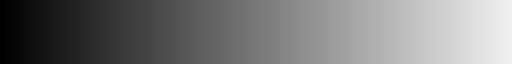

In [14]:
cvals = [0, 1]
colors = ["#000000", "#f0f0f0"]
norm = plt.Normalize(min(cvals), max(cvals))
tuples = list(zip(map(norm, cvals), colors))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)
cmap

### Sorting order

In [15]:
m = "k24"
sort_dict = {}
for g in gs:
	row_sums = df_features[(m, g)].sum(axis=1).to_dict()
	sort_dict.update({str(key): value for key, value in row_sums.items()})

In [16]:
json_dump(f"{PROJECT_DIR_o}labels/{s}_{m}_sum.json", sort_dict)

## Metaplots & heatmaps

In [17]:
def generate_metaplot_and_heatmap(d, ps, ms, df_metaplots, df_heatmaps, sort_file, ylims, yticks, cbar_ticks, cmap, outputfile, test, xlabel="Distance (kb)"):
	width_ratios = [5]*len(ms)+[1]
	height_ratios = [3,5,5]
	fig, axes = plt.subplots(3, len(width_ratios), figsize=(6, 4), gridspec_kw={'width_ratios': width_ratios, 'height_ratios': height_ratios})
	axes[0,len(ms)].axis("off")
	axes[2,len(ms)].axis("off")
	labelpad = 2
	y_align = -0.3
	wspace = 0.3
	hspace = 0.2

	hue_order = ["Ctrl", "Divergent", "Unidirectional"]
	palette = ["#d9d9d9", "#313695", "#de77ae"]
		
	for m in ms:
		col = ms.index(m)
		for row in range(3):
			ax = axes[row, col]
			# Metaplot
			if row == 0:
				utils.generate_feature_metaplot(df_metaplots[(m,d)], palette, hue_order, ax, test)
				
				ax.set_ylim(ylims)
				ax.set_yticks(yticks)
				if col == 0:
					ax.set_ylabel("Mappability", fontsize=bfontsize)
					ax.get_yaxis().set_label_coords(y_align, 0.5)
				else:
					ax.set_ylabel("")
					ax.set_yticklabels([])

				if col == len(ms)-1:
					ax.legend(loc="upper left", fontsize=sfontsize, bbox_to_anchor=[1.05, 1])
				else:
					ax.legend([],[], frameon=False)
					
			# Heatmap
			else:
				if row == 1:
					cbar = True
					cbar_ax = axes[row, len(ms)]
				else:
					cbar = False
					cbar_ax = None
				cbar_kws = {"ticks": cbar_ticks}

				utils.generate_feature_heatmap(df_heatmaps[(m,f"{ps[row-1]}_{d}")], cbar_ticks, cmap, cbar, cbar_ax, cbar_kws, ax, sort_file, test)

				if row == 1:
					cbar_ax.set_yticklabels(cbar_ticks)
					cbar_ax.tick_params(labelsize=sfontsize, pad=labelpad)

				if col == 0:
					ax.set_ylabel(ps[row-1].capitalize(), fontsize=bfontsize)
					ax.get_yaxis().set_label_coords(y_align/3, 0.5)
				else:
					ax.set_ylabel("")
				
			if row == 0:
				ax.set_title(m, fontsize=bfontsize, pad=labelpad+5)
		
			xtick_list = [0,500,1000]
			xticklabel_list = ["-0.5", "0", "0.5"]
			ax.set_xlim([0, 1000])
			ax.set_xticks(xtick_list)
			if row == 2:
				ax.set_xticklabels(xticklabel_list)
				ax.set_xlabel(xlabel, fontsize=bfontsize)
			else:
				ax.set_xticklabels([])
				ax.set_xlabel("")

			ax.tick_params(labelsize=sfontsize, pad=labelpad)

	fig.subplots_adjust(wspace=wspace, hspace=hspace)
	plt.savefig(outputfile, bbox_inches="tight", dpi=300, transparent=True) 

In [18]:
pwpool = ProcessWrapPool(len(ds))

ylims = [0.75, 1.05]
yticks = [0.8, 0.9, 1]
cbar_ticks = [0, 0.5, 1.0]
# test = True
test = False
sort_file = f"{PROJECT_DIR_o}labels/{s}_k24_sum.json"
for d in ds:
	if d == "distal":
		outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig2b.top.png"
	else:
		outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig2b.bottom.png"
	pwpool.run(generate_metaplot_and_heatmap, args=[d, ps, ms, df_metaplots, df_features, sort_file, ylims, yticks, cbar_ticks, cmap, outputfile, test])

In [21]:
len(pwpool.finished_tasks)

2

In [22]:
pwpool.close()